## Deliverable D - Data Mining

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import math
import pandas.io.sql as sqlio

In [3]:
! pip install psycopg2

  Using cached psycopg2-2.8.6-cp38-cp38-win_amd64.whl (1.1 MB)


### Database Connection and Queries

Database connected, queries are specified as strings

In [2]:
import psycopg2

In [20]:
f = open(r"C:\Users\samet\Documents\passwordpy.txt", "r")
password = f.readline()
conn = psycopg2.connect(
    host = "www.eecs.uottawa.ca",
    port = 15432,
    user = "syilm068",
    database = "group_20",
    password = password
)

In [4]:
fact_table_query = "SELECT * FROM fact_table"
patient_query = "SELECT * FROM d_patient"
weather_query = "SELECT * FROM d_weather"
special_query = "SELECT * FROM d_special_measures"
mobility_query = "SELECT * FROM d_mobility"

fact_table = sqlio.read_sql_query(fact_table_query, conn)
patient_table = sqlio.read_sql_query(patient_query, conn)
weather_query = sqlio.read_sql_query(weather_query, conn)
special_measures = sqlio.read_sql_query(special_query, conn)
mobility = sqlio.read_sql_query(mobility_query, conn)

#conn = None

In [21]:
residential_query  = '''SELECT DISTINCT m.mobility_key, m.residential, s.stay_at_home_order
FROM d_mobility m, d_special_measures s, fact_table f
WHERE f.mobility_key = m.mobility_key AND f.special_measures_key = s.surrogate_key'''

residential = sqlio.read_sql_query(residential_query, conn)


outbreaks_query = '''SELECT t1.*, 1 as SUM
FROM (SELECT p.outbreak_related, p.age, p.gender, p.acquisition_group, w.daily_mean,
s.stay_at_home_order, s.indoor_dining, s.gyms_open, m.workplaces, m.residential,
m.retail_and_recreation, SUM(f.fatal + f.resolved + f.unresolved)
FROM fact_table f, d_special_measures s, d_mobility m, d_patient p, d_weather w
WHERE f.patient_key = p.patient_surrogate_key AND f.weather_key = w.weather_key AND
f.mobility_key = m.mobility_key AND f.special_measures_key = s.surrogate_key

GROUP BY p.outbreak_related, p.age, p.gender, p.acquisition_group, w.daily_mean,
s.stay_at_home_order, s.indoor_dining, s.gyms_open, m.workplaces, m.residential,
m.retail_and_recreation) AS t1, generate_series(1, t1.sum)'''

outbreaks = sqlio.read_sql_query(outbreaks_query, conn)
conn = None

### Viewing the tables

In [8]:
fact_table.head()

,onset_date_key,reported_date_key,test_date_key,specimen_date_key,patient_key,phu_key,mobility_key,special_measures_key,weather_key,resolved,unresolved,fatal
0,0,275,275,106,0,0,181,7,180,1,0,0
1,12,239,239,12,195,0,145,6,144,1,0,0
2,25,221,221,219,65,0,127,5,126,1,0,0
3,40,233,233,83,243,0,139,5,138,1,0,0
4,128,290,290,288,111,0,196,8,195,1,0,0


In [9]:
fact_table.loc[(fact_table['resolved'] > 1) | (fact_table['unresolved'] > 1) | (fact_table['fatal'] > 1)]

,onset_date_key,reported_date_key,test_date_key,specimen_date_key,patient_key,phu_key,mobility_key,special_measures_key,weather_key,resolved,unresolved,fatal
114,208,218,218,216,69,0,124,5,123,2,0,0
206,211,218,218,215,9,0,124,5,123,2,0,0
213,211,218,218,216,9,0,124,5,123,3,0,0
218,211,218,218,216,249,0,124,5,123,2,0,0
245,211,221,221,220,401,0,127,5,126,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
56210,339,340,340,339,396,1,122,4,122,2,0,0
56212,339,340,340,339,400,0,246,10,245,2,0,0
56213,339,340,340,339,401,0,246,10,245,5,0,0
56216,339,340,340,339,405,0,246,10,245,2,0,0


In [10]:
patient_table.head()

,patient_surrogate_key,age,gender,acquisition_group,outbreak_related
0,0,40s,FEMALE,OB,True
1,1,40s,FEMALE,OB,False
2,2,40s,FEMALE,NO KNOWN EPI LINK,True
3,3,40s,FEMALE,NO KNOWN EPI LINK,False
4,4,40s,FEMALE,CC,True


In [11]:
weather_query.head()

,weather_key,daily_high_temp,daily_low_temp,total_precipitation,station_name,daily_mean,weather_date
0,0,2.7,-2.3,0.0,OTTAWA INTL A,0.2,2020-10-27
1,1,9.4,-1.1,0.4,OTTAWA INTL A,4.2,2020-10-28
2,2,6.0,-1.3,0.0,OTTAWA INTL A,2.4,2020-10-29
3,3,3.9,-4.9,0.0,OTTAWA INTL A,-0.5,2020-10-30
4,4,6.5,-8.4,0.0,OTTAWA INTL A,-1.0,2020-10-31


In [12]:
special_measures.head()

,surrogate_key,begin_date,end_date,city,zone_measures,description,key_word,lockdown,mandatory_masks,indoor_dining,gyms_open,stay_at_home_order,max_indoor_capacity,max_outdoor_capacity
0,0,2020-10-27,2020-12-26,Ottawa,Orange,Ottawa is designated as a Restrict/Orange Zone...,Indoor services limited to 50 people,0,1,1,1,0,50,100
1,1,2020-12-26,2021-01-12,Ottawa,Grey,Province wide lockdown begins,Lockdown,1,1,0,0,1,0,10
2,2,2021-01-12,2021-02-08,Ottawa,Grey,Ontario extends province wide lockdown,Lockdown extended,1,1,0,0,1,0,10
3,3,2021-02-08,2021-02-16,Ottawa,Grey,Ottawa lockdown for another week,Lockdown extended,1,1,0,0,1,0,10
4,4,2021-02-16,2021-02-27,Ottawa,Orange,"Ottawa stay-at home order ends, back to being ...",Indoor services limited to 50 people,0,1,1,1,0,50,100


In [13]:
mobility.head()

,mobility_key,subregion,province,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
0,0,Ottawa Division,Ontario,-31.0,-5.0,-15.0,-63.0,-53.0,19.0
1,1,Ottawa Division,Ontario,-31.0,-6.0,-9.0,-63.0,-52.0,19.0
2,2,Ottawa Division,Ontario,-28.0,-2.0,-21.0,-63.0,-52.0,19.0
3,3,Ottawa Division,Ontario,-32.0,-3.0,-2.0,-59.0,-48.0,19.0
4,4,Ottawa Division,Ontario,-26.0,3.0,51.0,-47.0,-6.0,6.0


### Viewing Complex Query Tables

In [14]:
# Idea for a good boxplot
residential.head()

,mobility_key,residential,stay_at_home_order
0,136,4.0,0
1,13,18.0,0
2,218,25.0,1
3,8,20.0,0
4,157,8.0,0


In [15]:
# Table containing all the attributes initially thought to be relevant to outbreaks
outbreaks[20:]

,outbreak_related,age,gender,acquisition_group,daily_mean,stay_at_home_order,indoor_dining,gyms_open,workplaces,residential,retail_and_recreation,sum,sum
20,False,20s,FEMALE,CC,-15.7,1,0,0,-60.0,27.0,-55.0,4,1
21,False,20s,FEMALE,CC,-15.4,1,0,0,-25.0,13.0,-51.0,2,1
22,False,20s,FEMALE,CC,-15.4,1,0,0,-25.0,13.0,-51.0,2,1
23,False,20s,FEMALE,CC,-14.7,1,0,0,-25.0,11.0,-53.0,3,1
24,False,20s,FEMALE,CC,-14.7,1,0,0,-25.0,11.0,-53.0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76451,True,<20,UNSPECIFIED,OB,-1.2,0,0,0,-51.0,21.0,-51.0,1,1
76452,True,<20,UNSPECIFIED,OB,3.4,0,0,0,-55.0,18.0,-32.0,1,1
76453,True,<20,UNSPECIFIED,OB,3.4,0,0,0,-48.0,20.0,-46.0,1,1
76454,True,<20,UNSPECIFIED,OB,5.8,0,0,0,-19.0,8.0,-43.0,1,1


[Text(0, 0.5, 'Residential Mobility'),
 Text(0.5, 0, 'Stay at Home Order (0 = No/1 = Yes)')]

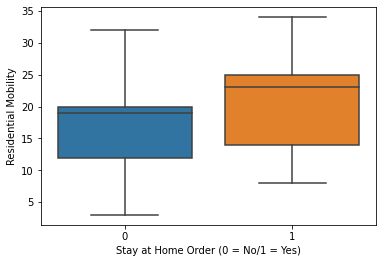

In [16]:
residential_mobility = residential['residential']
at_home = residential['stay_at_home_order']
boxplot_residential = sb.boxplot(x = "stay_at_home_order", y = "residential", data = residential)
boxplot_residential.set(xlabel = "Stay at Home Order (0 = No/1 = Yes)", ylabel = "Residential Mobility")

In [22]:
outbreaks['age'] = outbreaks['age'].str.replace('s', '')
outbreaks['age'] = outbreaks['age'].str.replace('+', '')
outbreaks['age'] = outbreaks['age'].str.replace('<', '')
outbreaks['age'] = outbreaks['age'].str.replace('UNKNOWN', '0')
outbreaks['age'] = pd.to_numeric(outbreaks['age'])

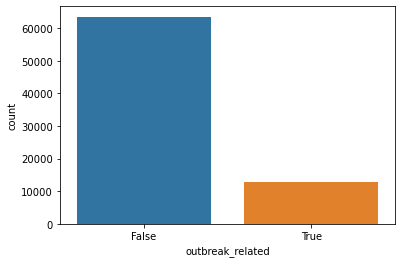

In [47]:
# We might consider this a Class imbalance
countplot = sb.countplot(x = outbreaks['outbreak_related'])

76456


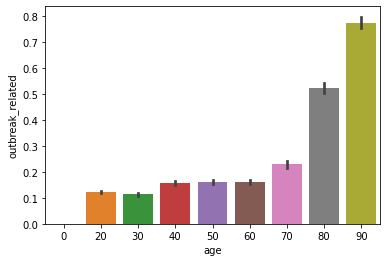

In [32]:
print(len(outbreaks['outbreak_related']))
boxplot_test1 = sb.barplot(y = outbreaks['outbreak_related'], x = outbreaks["age"])

### Acquisition Group
 We see Acquisition Group already has an outbreak category. We will therefore drop this feature in our models.

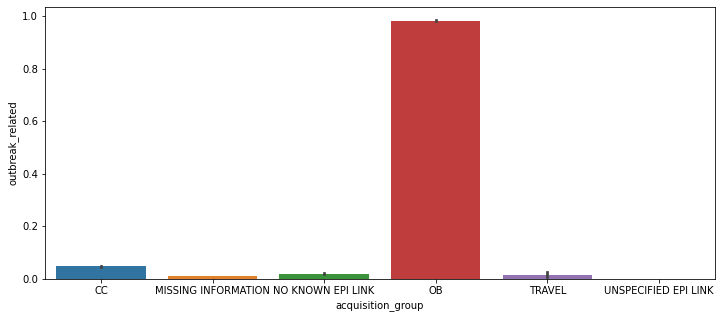

In [44]:
#Dropping accquisition group since it has an outbreak attribute alrady.
plt.figure(figsize = (12,5))
barplot_test2 = sb.barplot(y = outbreaks['outbreak_related'], x = outbreaks["acquisition_group"])
plt.show()

In [ ]:
outbreaks['gender'] = outbreaks['gender'].str.replace('U')
